In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

LOAD AND EXPLORE DATASET

In [2]:
print("Loading dataset...")
df = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")

Loading dataset...


In [3]:
print("\n--- DATASET PREVIEW (First 5 Rows) ---")
print(df.head())


--- DATASET PREVIEW (First 5 Rows) ---
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [4]:
print("\n--- DATASET STRUCTURE & NULLS ---")
print(df.info())


--- DATASET STRUCTURE & NULLS ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [5]:
print("\n--- UNIQUE TRANSACTION TYPES ---")
print(df['type'].unique())


--- UNIQUE TRANSACTION TYPES ---
['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


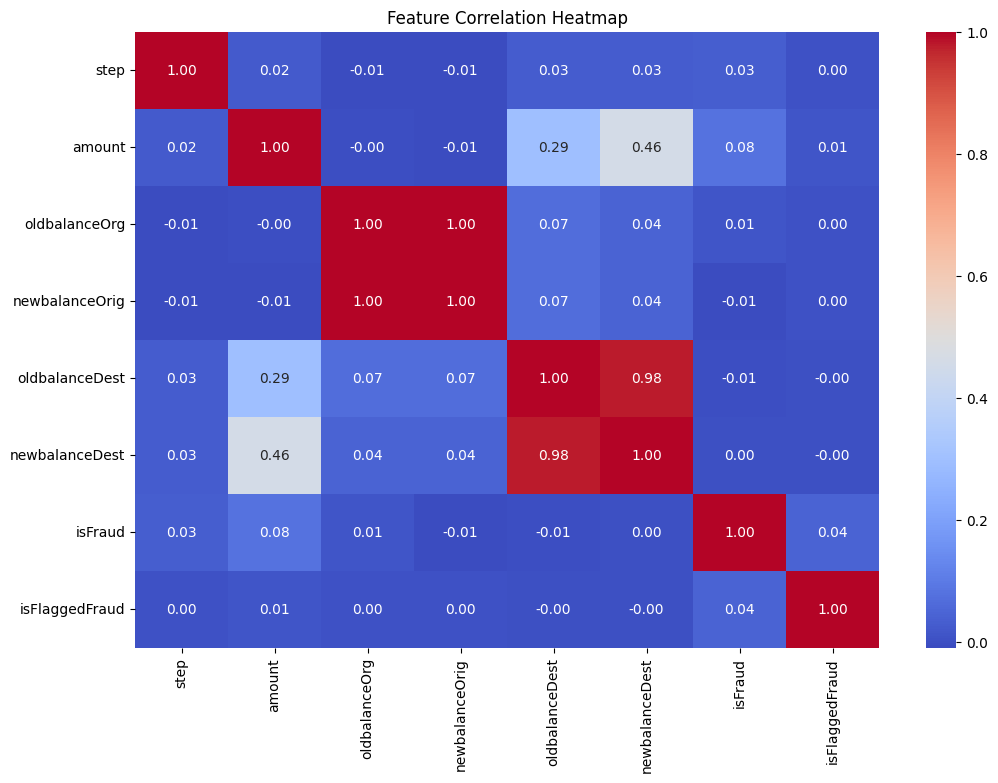

In [6]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

DESCRIPTIVE ANALYSIS

In [7]:
print("\n📊 --- DESCRIPTIVE ANALYSIS ---")
print(f"Dataset Shape: {df.shape}")
print("\nData Types and Null Values:")
print(df.info())


📊 --- DESCRIPTIVE ANALYSIS ---
Dataset Shape: (6362620, 11)

Data Types and Null Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [8]:
print("\nSummary Statistics for Numerical Features:")
print(df.describe())


Summary Statistics for Numerical Features:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000

UNIVARIATE ANALYSIS

In [9]:
print("\n📈 --- UNIVARIATE ANALYSIS ---")
# Checking the distribution of the Target variable
fraud_counts = df['isFraud'].value_counts()
fraud_percentage = (fraud_counts / len(df)) * 100
print(f"Fraud vs Legitimate counts:\n{fraud_counts}")
print(f"Fraud Percentage: {fraud_percentage[1]:.4f}%")


📈 --- UNIVARIATE ANALYSIS ---
Fraud vs Legitimate counts:
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud Percentage: 0.1291%


/tmp/ipython-input-1457441298.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='viridis')


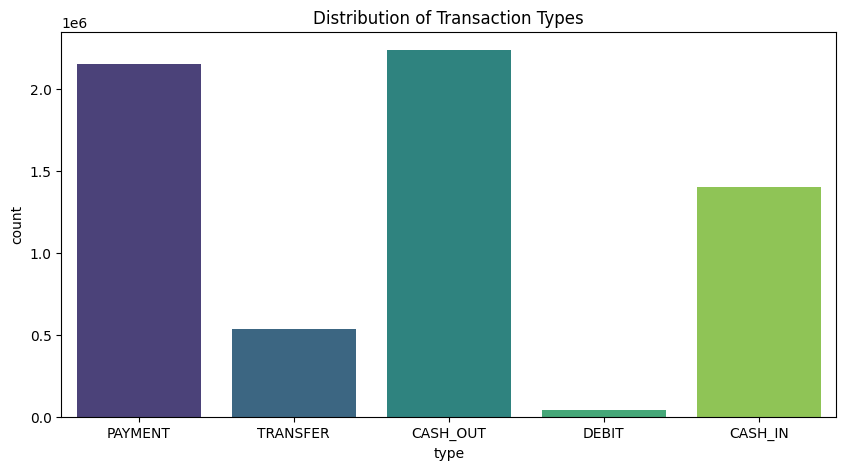

In [10]:
# Visualize Transaction Types
plt.figure(figsize=(10, 5))
sns.countplot(x='type', data=df, palette='viridis')
plt.title('Distribution of Transaction Types')
plt.show()

<Axes: xlabel='step'>

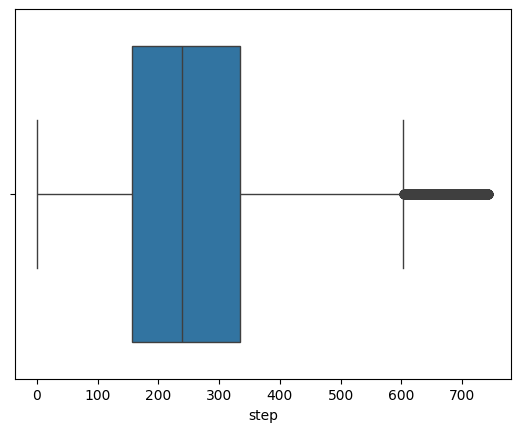

In [11]:
sns.boxplot(data=df,x='step')

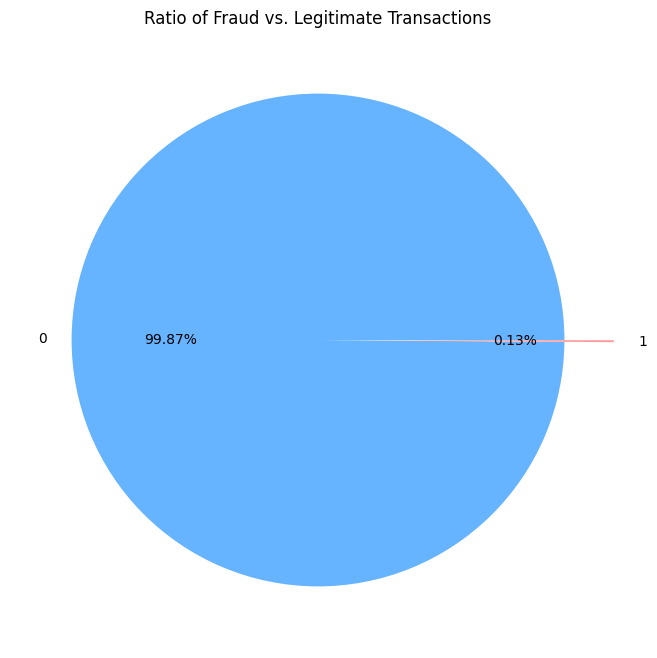

In [12]:
# Visually demonstrates the extreme imbalance before SMOTE
plt.figure(figsize=(8, 8))
df['isFraud'].value_counts().plot.pie(autopct='%1.2f%%', colors=['#66b3ff','#ff9999'], explode=(0, 0.2))
plt.title('Ratio of Fraud vs. Legitimate Transactions')
plt.ylabel('') # Hides the 'isFraud' label on the side
plt.show()

BIVARIATE ANALYSIS

In [13]:
print("\n🔍 --- BIVARIATE ANALYSIS ---")
# Relationship between Transaction Type and Fraud
print("Fraud occurrence by Transaction Type:")
print(df.groupby('type')['isFraud'].sum())


🔍 --- BIVARIATE ANALYSIS ---
Fraud occurrence by Transaction Type:
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


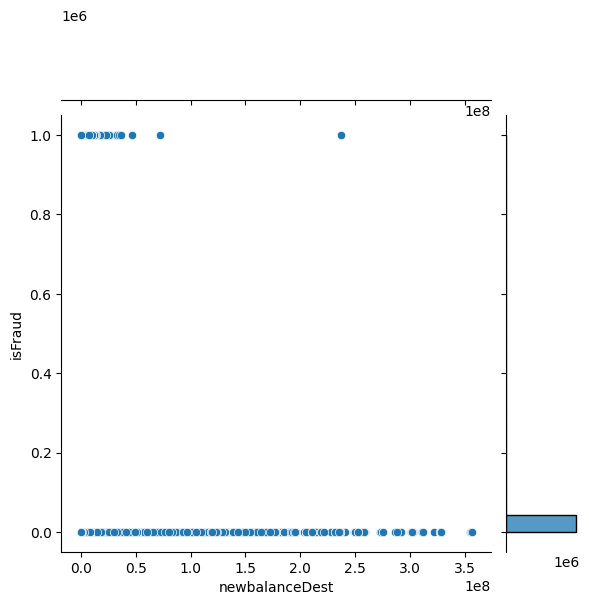

In [14]:
sns.jointplot(data=df,x='newbalanceDest',y='isFraud')

<Axes: xlabel='type', ylabel='count'>

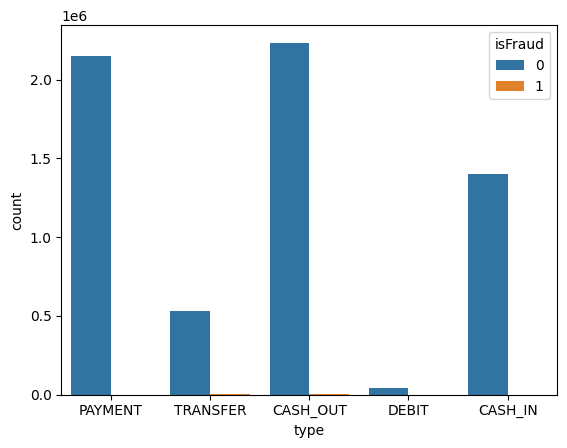

In [15]:
sns.countplot(data=df, x='type', hue='isFraud')

<Axes: xlabel='isFraud', ylabel='step'>

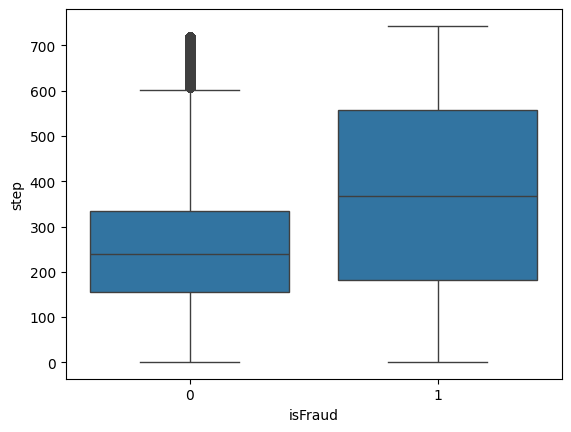

In [16]:
# Visualizing the relationship between isFraud and step
sns.boxplot(data=df, x='isFraud', y='step')

<Axes: xlabel='isFraud', ylabel='amount'>

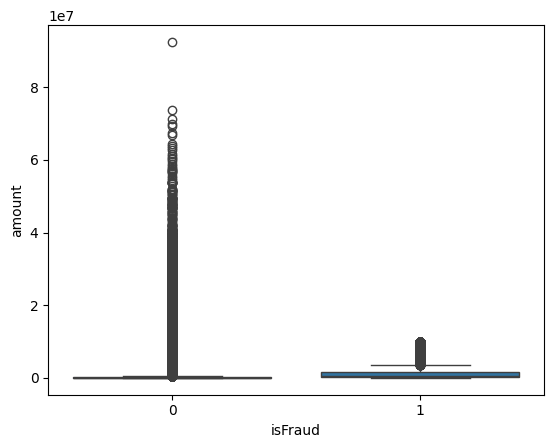

In [17]:
# Visualizing the relationship between isFraud and amount
sns.boxplot(data=df, x='isFraud', y='amount')

<Axes: xlabel='isFraud', ylabel='oldbalanceOrg'>

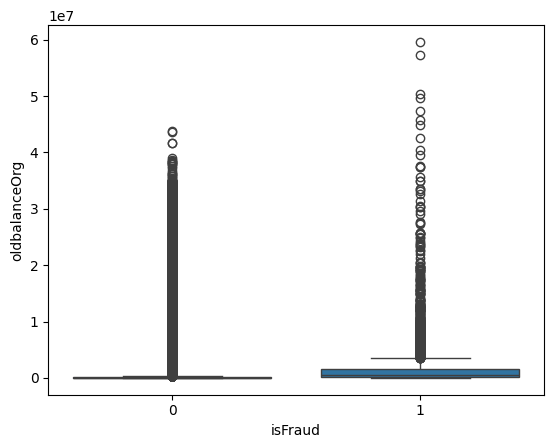

In [18]:
# Visualizing the relationship between isFraud and oldbalanceOrg
sns.boxplot(data=df, x='isFraud', y='oldbalanceOrg')

<Axes: xlabel='isFraud', ylabel='newbalanceOrig'>

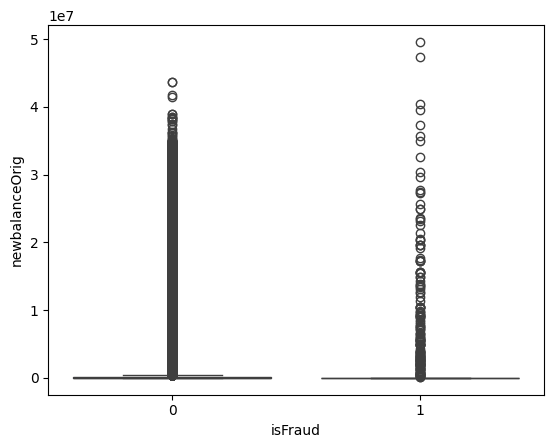

In [19]:
# Visualizing the relationship between isFraud and newbalanceOrig
sns.boxplot(data=df, x='isFraud', y='newbalanceOrig')

FEATURE ENGINEERING & CLEANING

In [20]:
print("\n🛠️ Preprocessing and Feature Engineering...")
# The 'Math Check' features
df['errorBalanceOrig'] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
df['errorBalanceDest'] = df.oldbalanceDest + df.amount - df.newbalanceDest


🛠️ Preprocessing and Feature Engineering...


In [21]:
# Drop non-numeric IDs
df_clean = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [22]:
# Encode Transaction Types
type_map = {"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5}
df_clean["type"] = df_clean["type"].map(type_map)

In [23]:
X = df_clean.drop('isFraud', axis=1)
y = df_clean['isFraud']

VERIFY BALANCE (BEFORE SMOTE)

In [24]:
print("\n📊 --- CLASS BALANCE BEFORE SMOTE ---")
print(y.value_counts())
print(f"Fraud Ratio: {y.mean():.4%}")


📊 --- CLASS BALANCE BEFORE SMOTE ---
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud Ratio: 0.1291%


APPLY SMOTE

In [25]:
print("\n⚖️ Balancing dataset using SMOTE...")
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


⚖️ Balancing dataset using SMOTE...


VERIFY BALANCE (AFTER SMOTE)

In [26]:
print("\n✅ --- CLASS BALANCE AFTER SMOTE ---")
print(y_res.value_counts())
print(f"Fraud Ratio: {y_res.mean():.4%}")


✅ --- CLASS BALANCE AFTER SMOTE ---
isFraud
0    6354407
1    6354407
Name: count, dtype: int64
Fraud Ratio: 50.0000%


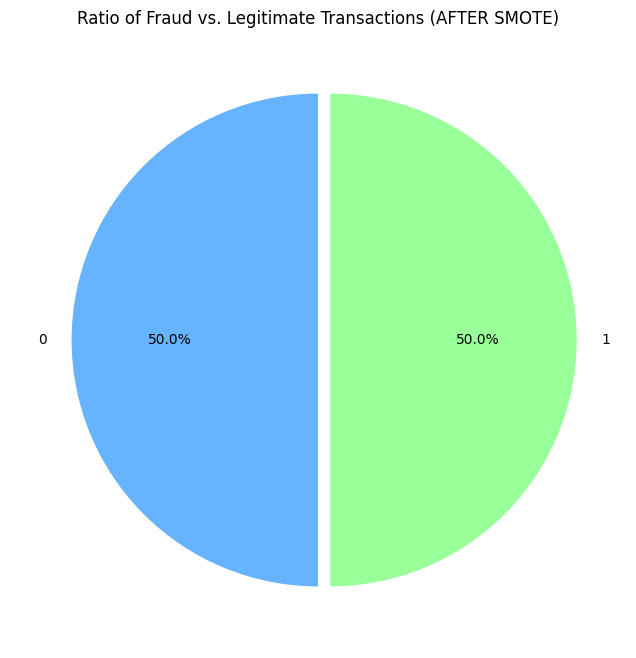

--- After SMOTE Counts ---
isFraud
0    6354407
1    6354407
Name: count, dtype: int64


In [27]:
import matplotlib.pyplot as plt

# 1. Count the values in the resampled target
after_smote_counts = y_res.value_counts()

# 2. Plot the Pie Chart
plt.figure(figsize=(8, 8))
after_smote_counts.plot.pie(
    autopct='%1.1f%%',
    colors=['#66b3ff','#99ff99'],
    explode=(0, 0.05),
    startangle=90
)

plt.title('Ratio of Fraud vs. Legitimate Transactions (AFTER SMOTE)')
plt.ylabel('') # Hides the 'isFraud' label on the side
plt.show()

# Print the actual numbers for confirmation
print("--- After SMOTE Counts ---")
print(after_smote_counts)

TRAIN & EVALUATE

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [29]:
print("🚀 Training XGBoost (Optimized for Recall)...")
model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=99,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

🚀 Training XGBoost (Optimized for Recall)...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

EVALUATE & SAVE

In [ ]:
y_pred = model.predict(X_test)
print("\n--- PERFORMANCE REPORT ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


--- PERFORMANCE REPORT ---
Accuracy : 0.9966
Recall   : 1.0000
F1-Score : 0.9966

Confusion Matrix:
[[1262189    8648]
 [     17 1270909]]


In [ ]:
with open('best_fraud_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("\n✅ Model saved as 'best_fraud_model.pkl'")


✅ Model saved as 'best_fraud_model.pkl'


Random Forest

In [ ]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

print("🌲 Training Random Forest (Optimized for Recall)...")

# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    class_weight={0: 1, 1: 99},
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

print("\n--- PERFORMANCE REPORT ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# --- SAVE THE MODEL USING PICKLE ---
filename = 'rf_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"\n✅ Model saved successfully as: {filename}")

🌲 Training Random Forest (Optimized for Recall)...

--- PERFORMANCE REPORT ---
Accuracy : 0.9811
Recall   : 0.9995
F1-Score : 0.9814

Confusion Matrix:
[[1223336   47501]
 [    576 1270350]]

✅ Model saved successfully as: rf_model.pkl


PREDICTION FUNCTION & TESTING

In [ ]:

def predict_transaction(data_list):
    with open('best_fraud_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)

    step, tx_type, amount, old_org, new_org, old_dest, new_dest = data_list
    error_org = new_org + amount - old_org
    error_dest = old_dest + amount - new_dest

    final_features = np.array([[step, tx_type, amount, old_org, new_org, old_dest, new_dest, error_org, error_dest]])
    probability = loaded_model.predict_proba(final_features)[0][1] * 100

    print("-" * 35)
    if probability > 75:
        status = "🔴 FRAUD DETECTED"
    elif probability > 30:
        status = "⚠️ SUSPICIOUS ACTIVITY"
    else:
        status = "🟢 LEGITIMATE"

    print(f"Status: {status}")
    print(f"Confidence: {probability:.2f}%")
    print("-" * 35)

